# **Model Selection**

## Import Libraries

In [37]:
import pandas as pd
import numpy as np
import math
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance

import shap

## Load Dataset

In [38]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')
df = df.sample(frac=0.25, random_state=10)

## Explore the Data

In [39]:
df.shape

(364661, 11)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364661 entries, 112342 to 786613
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  364661 non-null  object 
 1   vendor_id           364661 non-null  int64  
 2   pickup_datetime     364661 non-null  object 
 3   dropoff_datetime    364661 non-null  object 
 4   passenger_count     364661 non-null  int64  
 5   pickup_longitude    364661 non-null  float64
 6   pickup_latitude     364661 non-null  float64
 7   dropoff_longitude   364661 non-null  float64
 8   dropoff_latitude    364661 non-null  float64
 9   store_and_fwd_flag  364661 non-null  object 
 10  trip_duration       364661 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 33.4+ MB


In [41]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
112342,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,660
840803,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,1833
184538,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,490
512001,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,767
776055,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,199


In [42]:
df['dropoff_datetime'].min()

'2016-01-01 00:12:42'

In [43]:
df['dropoff_datetime'].max()

'2016-07-01 13:26:40'

In [44]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [45]:
(df.isnull().sum()/(len(df)))*100

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

In [46]:
df.nunique()

id                    364661
vendor_id                  2
pickup_datetime       359649
dropoff_datetime      359550
passenger_count            9
pickup_longitude       16806
pickup_latitude        34806
dropoff_longitude      22718
dropoff_latitude       44747
store_and_fwd_flag         2
trip_duration           5407
dtype: int64

In [47]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,364661.0,1.535958,0.498706,1.000000,1.000000,2.000000,2.000000,2.000000
passenger_count,364661.0,1.666049,1.316111,0.000000,1.000000,1.000000,2.000000,9.000000
pickup_longitude,364661.0,-73.973406,0.044367,-77.440750,-73.991875,-73.981705,-73.967285,-61.335529
pickup_latitude,364661.0,40.750939,0.031035,35.310307,40.737442,40.754108,40.768391,41.319164
dropoff_longitude,364661.0,-73.973412,0.043817,-79.817978,-73.991341,-73.979790,-73.963036,-61.335529
dropoff_latitude,364661.0,40.751834,0.035182,35.173546,40.735840,40.754559,40.769878,41.480755
trip_duration,364661.0,954.927448,3203.464143,1.000000,397.000000,662.000000,1076.000000,86390.000000


## Preliminary Feature Engineering

### Create new features from pickup_datetime and dropoff_datetime

In [48]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [49]:
df['pickup_day'] = df['pickup_datetime'].dt.day_name()
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_month'] = df['pickup_datetime'].dt.month

In [50]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month
112342,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,660,Saturday,5,0,1
840803,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,1833,Wednesday,2,19,2
184538,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,490,Thursday,3,6,5
512001,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,767,Thursday,3,8,1
776055,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,199,Saturday,5,13,1


### Calculate Haversine great-circle distance

In [51]:
def calculate_haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the great-circle distance between two points
    on a sphere given their longitudes and latitudes.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])    
    dlon = lon2 - lon1
    dlat = lat2 - lat1   
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6378.137 * c
    
    return haversine_distance

In [52]:
df['haversine_distance'] = calculate_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance
112342,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,660,Saturday,5,0,1,1.341484
840803,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,1833,Wednesday,2,19,2,4.818762
184538,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,490,Thursday,3,6,5,2.016166
512001,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,767,Thursday,3,8,1,1.730221
776055,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,199,Saturday,5,13,1,0.650929


### Calculate Manhattan distance

In [53]:
def calculate_manhattan_distance(lat1, lon1, lat2, lon2):
    """
    Calculates Manhattan distance between two points using their latitude and longitude.
    """
    a = calculate_haversine_distance(lat1, lon1, lat1, lon2)
    b = calculate_haversine_distance(lat1, lon1, lat2, lon1)
    manhattan_distance = a + b
    
    return manhattan_distance

In [54]:
df['manhattan_distance'] = df.apply(lambda row: calculate_manhattan_distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance
112342,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,660,Saturday,5,0,1,1.341484,1.748711
840803,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,1833,Wednesday,2,19,2,4.818762,6.813560
184538,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,490,Thursday,3,6,5,2.016166,2.383142
512001,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,767,Thursday,3,8,1,1.730221,2.104292
776055,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,199,Saturday,5,13,1,0.650929,0.920104


### Convert latitude and longitude to Polar coordinates

In [55]:
def convert_to_polar_coordinates(lat, lon):
    """
    Converts latitude and longitude to polar coordinates.
    """
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)

    # Convert to polar coordinates
    r = math.sqrt(lat_rad**2 + lon_rad**2)
    phi = math.atan2(lon_rad, lat_rad)

    return r, phi

In [56]:
df['pickup_r'], df['pickup_phi'] = zip(*df.apply(lambda row: convert_to_polar_coordinates(row['pickup_latitude'], row['pickup_longitude']), axis=1))
df['dropoff_r'], df['dropoff_phi'] = zip(*df.apply(lambda row: convert_to_polar_coordinates(row['dropoff_latitude'], row['dropoff_longitude']), axis=1))

In [57]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi
112342,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,...,Saturday,5,0,1,1.341484,1.748711,1.474370,-1.067662,1.474106,-1.067625
840803,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,...,Wednesday,2,19,2,4.818762,6.813560,1.474095,-1.066935,1.474465,-1.067482
184538,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,...,Thursday,3,6,5,2.016166,2.383142,1.473979,-1.067677,1.474306,-1.067848
512001,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,...,Thursday,3,8,1,1.730221,2.104292,1.474064,-1.067117,1.474268,-1.066989
776055,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,...,Saturday,5,13,1,0.650929,0.920104,1.473876,-1.066884,1.473824,-1.066810


### Calculate bearing

In [58]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates bearing between two points using their latitude and longitude.
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Calculate the difference in longitudes
    dlon = lon2 - lon1

    # Calculate the bearing angle
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    initial_bearing = np.arctan2(x, y)

    # Normalize the initial bearing to 0° ... 360°
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [59]:
df['bearing'] = df.apply(lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing
112342,id2631171,2,2016-01-23 00:09:14,2016-01-23 00:20:14,1,-74.006615,40.731712,-73.991890,40.727161,N,...,5,0,1,1.341484,1.748711,1.474370,-1.067662,1.474106,-1.067625,112.183219
840803,id2892416,1,2016-02-10 19:24:14,2016-02-10 19:54:47,3,-73.963203,40.777924,-74.004059,40.747654,N,...,2,19,2,4.818762,6.813560,1.474095,-1.066935,1.474465,-1.067482,225.645152
184538,id3095142,2,2016-05-12 06:39:26,2016-05-12 06:47:36,1,-73.987595,40.719822,-74.010994,40.716148,N,...,3,6,5,2.016166,2.383142,1.473979,-1.067677,1.474306,-1.067848,258.305158
512001,id3803823,2,2016-01-21 08:31:03,2016-01-21 08:43:50,1,-73.969055,40.763618,-73.974129,40.778679,N,...,3,8,1,1.730221,2.104292,1.474064,-1.067117,1.474268,-1.066989,345.689279
776055,id3155730,2,2016-01-02 13:12:33,2016-01-02 13:15:52,2,-73.950165,40.775635,-73.944534,40.779636,N,...,5,13,1,0.650929,0.920104,1.473876,-1.066884,1.473824,-1.066810,46.814269


## Outlier Handling

### Passenger count

In [60]:
df = df[df['passenger_count'] > 0]
df = df[df['passenger_count'] < 7]

### Lonitude and latitude

In [61]:
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['pickup_longitude'] >= -74.03]
df = df[df['pickup_latitude'] <= 40.85]
df = df[df['pickup_latitude'] >= 40.63]
df = df[df['dropoff_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] >= -74.03]
df = df[df['dropoff_latitude'] <= 40.85]
df = df[df['dropoff_latitude'] >= 40.63]

### Trip duration - Taget

In [62]:
df['trip_duration'].mean() / 60

15.687235400090078

In [63]:
df['trip_duration_zscore'] = (df['trip_duration'] - df['trip_duration'].mean())/df['trip_duration'].std(ddof=0)
df.sort_values(by=['trip_duration_zscore'], ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing,trip_duration_zscore
73816,id0953667,2,2016-05-06 00:00:10,2016-05-07 00:00:00,1,-73.996010,40.753220,-73.979027,40.740601,N,...,0,5,2.006169,2.836882,1.474388,-1.067378,1.474023,-1.067412,134.438432,26.766388
753765,id2589925,2,2016-05-17 22:22:56,2016-05-18 22:22:35,4,-74.006111,40.734680,-73.958809,40.815449,N,...,22,5,9.835698,12.981118,1.474387,-1.067628,1.474344,-1.066521,23.901930,26.762942
1221666,id3346235,2,2016-05-09 15:59:04,2016-05-10 15:58:42,5,-73.982658,40.761963,-73.988976,40.743023,N,...,15,5,2.174646,2.641028,1.474258,-1.067211,1.474195,-1.067444,194.181914,26.762629
66346,id2307896,2,2016-05-14 04:48:05,2016-05-15 04:47:42,1,-74.000504,40.732121,-73.994202,40.712418,N,...,4,5,2.256838,2.724909,1.474280,-1.067623,1.474017,-1.067791,166.372019,26.762316
1282413,id3741436,2,2016-02-21 00:46:56,2016-02-22 00:46:21,3,-73.986298,40.734531,-73.992271,40.749088,N,...,0,2,1.696987,2.124365,1.474083,-1.067517,1.474297,-1.067400,342.730132,26.758557


In [64]:
df = df[df['trip_duration_zscore'] < 2]
df.drop(['trip_duration_zscore'], axis=1, inplace=True)

## Feature Correlations (Numerical Features)

In [65]:
numeric = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.select_dtypes(include=numeric)
df_numeric.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing
112342,2,1,-74.006615,40.731712,-73.991890,40.727161,660,5,0,1,1.341484,1.748711,1.474370,-1.067662,1.474106,-1.067625,112.183219
840803,1,3,-73.963203,40.777924,-74.004059,40.747654,1833,2,19,2,4.818762,6.813560,1.474095,-1.066935,1.474465,-1.067482,225.645152
184538,2,1,-73.987595,40.719822,-74.010994,40.716148,490,3,6,5,2.016166,2.383142,1.473979,-1.067677,1.474306,-1.067848,258.305158
512001,2,1,-73.969055,40.763618,-73.974129,40.778679,767,3,8,1,1.730221,2.104292,1.474064,-1.067117,1.474268,-1.066989,345.689279
776055,2,2,-73.950165,40.775635,-73.944534,40.779636,199,5,13,1,0.650929,0.920104,1.473876,-1.066884,1.473824,-1.066810,46.814269


<Axes: >

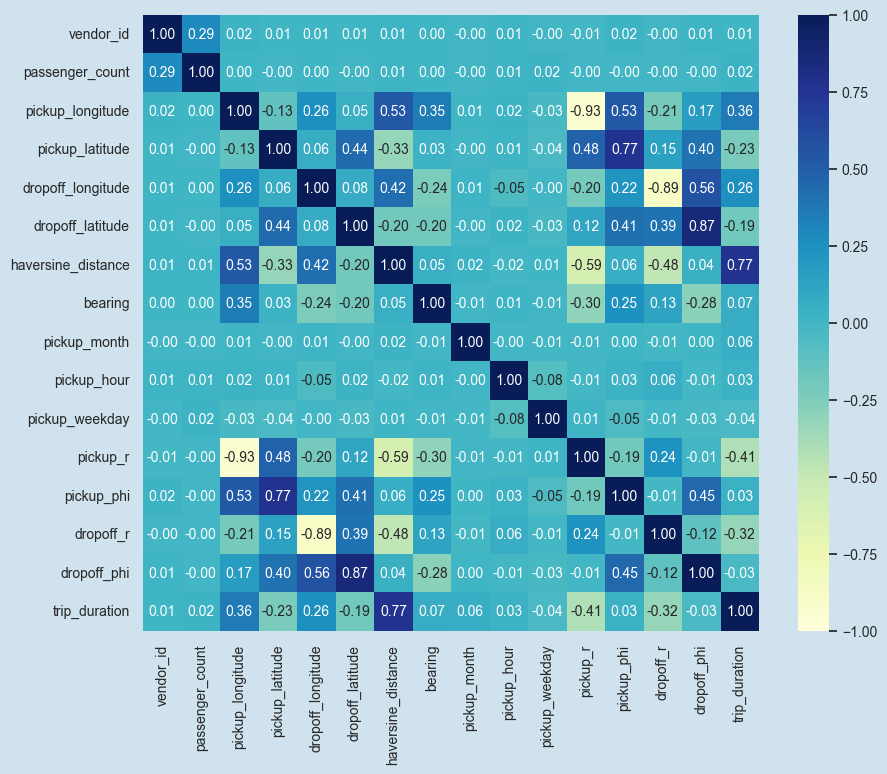

In [66]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(10, 8), 'grid.linestyle': '--'})

num_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'haversine_distance', 'bearing', 'pickup_month', 'pickup_hour', 'pickup_weekday', 'pickup_r', 'pickup_phi', 'dropoff_r', 'dropoff_phi']
num_features_target = copy.copy(num_features)
num_features_target.append('trip_duration')
sns.heatmap(data=df[num_features_target].corr(), square=True, annot=True, annot_kws={'size': 10}, fmt=".2f", vmin=-1, vmax=1, cmap="YlGnBu")

## Train Various Regression Models and Select a V0 Candidate

In [67]:
num_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'haversine_distance', 'bearing', 'pickup_month', 'pickup_hour', 'pickup_weekday', 'pickup_r', 'pickup_phi', 'dropoff_r', 'dropoff_phi']
# cat_features = ['pickup_day']
features = num_features
target = 'trip_duration'

In [68]:
y = df[target]
X = df[features]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

In [70]:
model_dt = DecisionTreeRegressor(random_state=10)
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)
print('Decision Tree Regression Performance Metrics')
print("Mean Absolute Error: " + str(mean_absolute_error(predictions_dt, y_test)))
print("Mean Squared Error: " + str(mean_squared_error(predictions_dt, y_test)))
print("Root Mean Squared Error: " + str(root_mean_squared_error(predictions_dt, y_test)))
print("R^2: " + str(r2_score(predictions_dt, y_test)))

Decision Tree Regression Performance Metrics
Mean Absolute Error: 262.40535159893636
Mean Squared Error: 174560.35091676065
Root Mean Squared Error: 417.8042016504389
R^2: 0.5841752137785425


In [71]:
model_rf = RandomForestRegressor(random_state=10)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
print('Random Forest Regression Performance Metrics')
print("Mean Absolute Error: " + str(mean_absolute_error(predictions_rf, y_test)))
print("Mean Squared Error: " + str(mean_squared_error(predictions_rf, y_test)))
print("Root Mean Squared Error: " + str(root_mean_squared_error(predictions_rf, y_test)))
print("R^2: " + str(r2_score(predictions_rf, y_test)))

Random Forest Regression Performance Metrics
Mean Absolute Error: 185.01402919665688
Mean Squared Error: 84237.31979425802
Root Mean Squared Error: 290.2366616991348
R^2: 0.7387657783875367


In [72]:
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=10)
# model_xgb = XGBRegressor(random_state=10)
model_xgb.fit(X_train, y_train)
predictions_xgb = model_xgb.predict(X_test)
print('XGBoost Regression Performance Metrics')
print("Mean Absolute Error: " + str(mean_absolute_error(predictions_xgb, y_test)))
print("Mean Squared Error: " + str(mean_squared_error(predictions_xgb, y_test)))
print("Root Mean Squared Error: " + str(root_mean_squared_error(predictions_xgb, y_test)))
print("R^2: " + str(r2_score(predictions_xgb, y_test)))

XGBoost Regression Performance Metrics
Mean Absolute Error: 174.37417224010193
Mean Squared Error: 77776.87220151459
Root Mean Squared Error: 278.88505195064613
R^2: 0.7628591404519438


## Classic Feature Importances (XGBoost)

#### Global feature importance calcuations are included with XGBoost library. But they calculate feature importances based on different importace types: Weight, Gain and Cover.
#### This could lead to inconsistency in calculating feature importances since one of the types needs to be selected based on reasoning that could change over time.
#### To resolve this, a SHAP (SHapley Additive exPlanations) concept is used. SHAP is a game theoretic approach to explain the output of any machine learning model.

Text(0.5, 1.0, 'Feature Importance (Importance Type: Weight)')

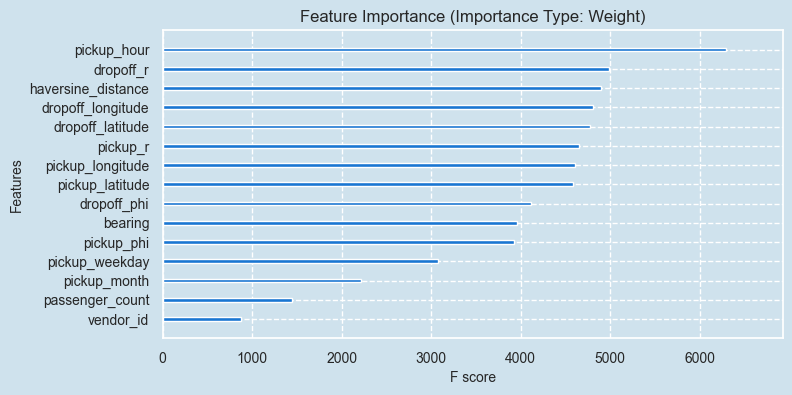

In [73]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model_xgb, importance_type='weight', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Weight)')

Text(0.5, 1.0, 'Feature Importance (Importance Type: Gain)')

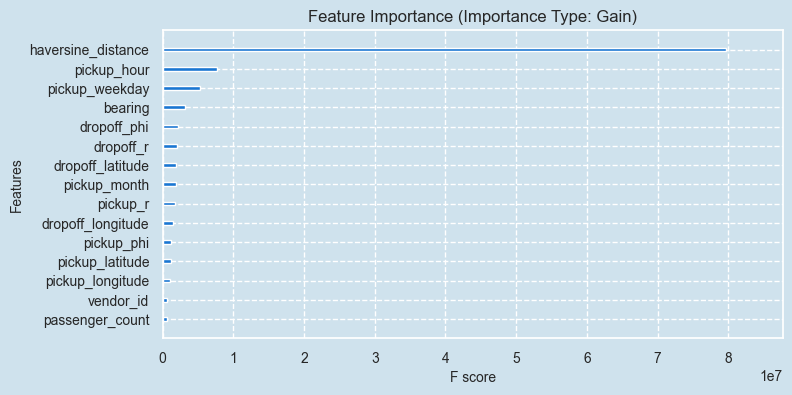

In [74]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model_xgb, importance_type='gain', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Gain)')

Text(0.5, 1.0, 'Feature Importance (Importance Type: Cover)')

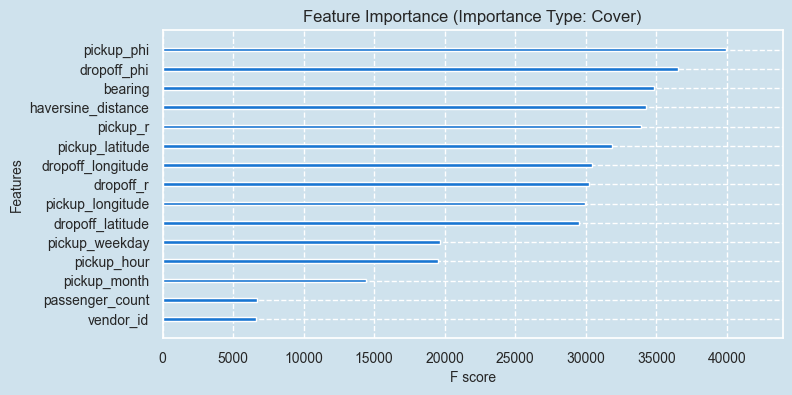

In [75]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model_xgb, importance_type='cover', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Cover)')

## Feature Importances (SHAP)

In [83]:
# Load JS visualization code to notebook
# shap.initjs()

In [84]:
X_sampled = X_train.sample(10000, random_state=10)

In [85]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_sampled)

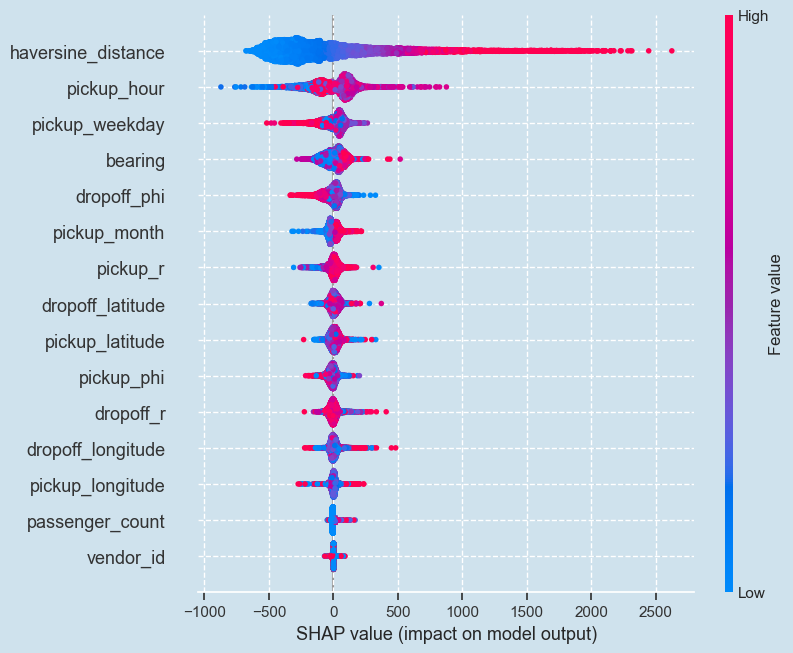

In [86]:
# Summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(features))

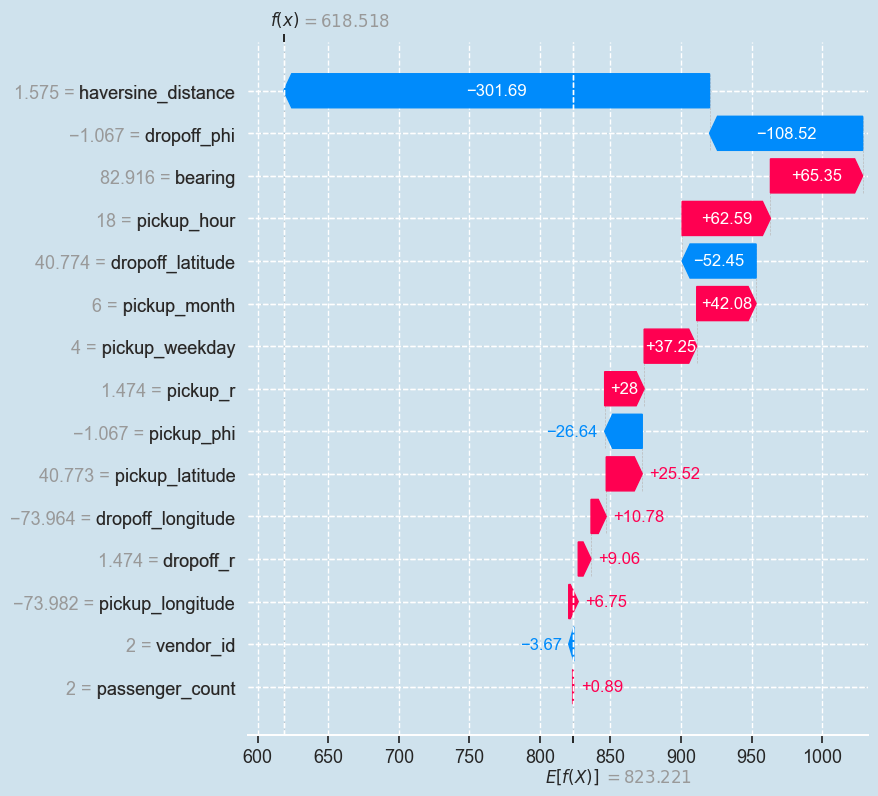

In [87]:
# Visualize the model v0 prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=len(features))

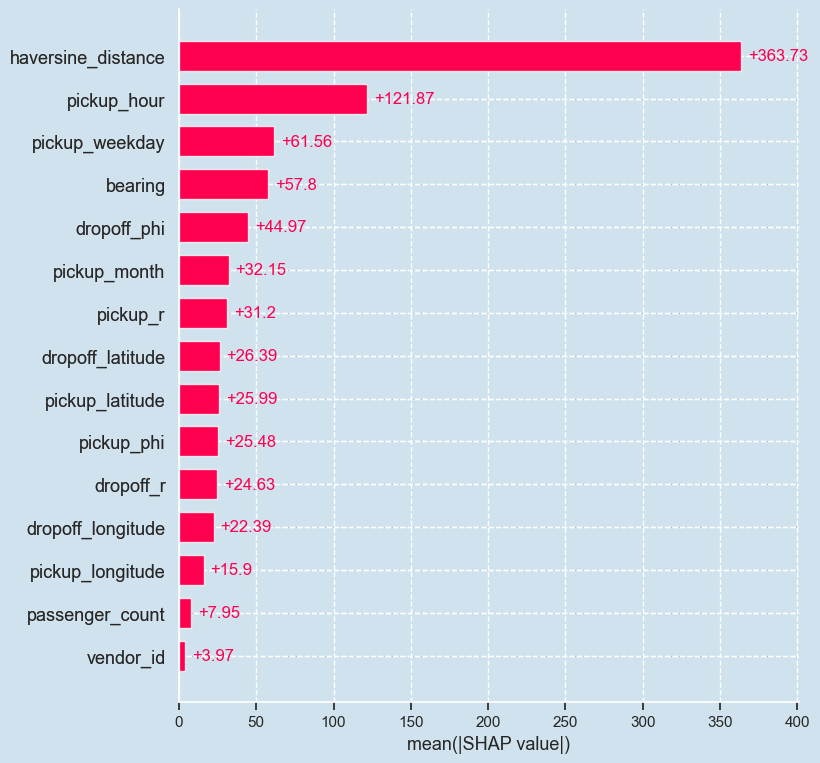

In [88]:
# Feature importance bar chart
shap.plots.bar(shap_values, max_display=len(features))

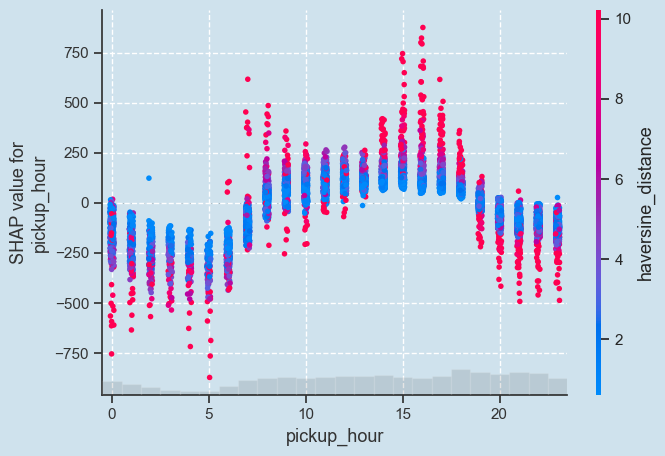

In [89]:
# Create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "pickup_hour"], color=shap_values)